# Neptune STAB Project
### author: Klaas Meinke

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

### Zonal Winds
Empirical function taken from p. 17 of: Neptune’s Atmospheric Circulation and Cloud Morphology <br>
based on 1998 hubble observations <br>
not accurate near the poles where u should be near 0 <br>
latitude input in deg

Text(0.5, 1.0, 'Zonal Winds')

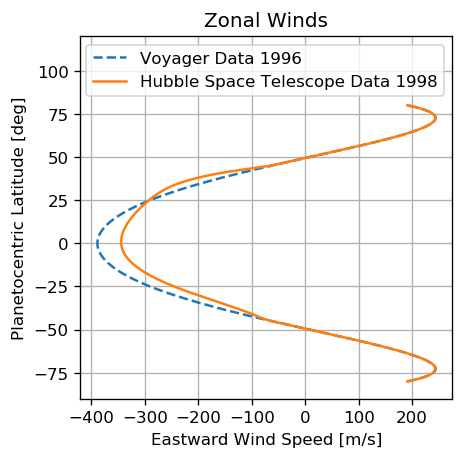

In [2]:
# Zonal Wind Functions
plt.rcParams['figure.dpi'] = 120 
plt.rcParams['figure.figsize'] = (4,4)

def wind_vyg(lat):
    u_vyg = -389+0.153*lat**2+1.01*10**-5*lat**4-3.1*10**-9*lat**6
    return(u_vyg)

def wind_hst(lat):  
    u_vyg = wind_vyg(lat)
    h = 45*np.exp(-(abs(lat)-44))/(1+np.exp(-(abs(lat)-44)))
    g = 1-np.exp(-(abs(lat)-51)/12)/(1+np.exp(-(abs(lat)-51)/12))
    u_hst = u_vyg + h*np.cos(np.pi*lat/98+8*g)
    return (u_hst)

# Plot
lat_min = -80
lat_max = 80
lat_steps = 500

lat_tab = np.linspace(lat_min, lat_max, lat_steps)
wind_vyg_tab = []
wind_hst_tab = []

for lat in lat_tab:
    wind_vyg_tab.append(wind_vyg(lat))    
    wind_hst_tab.append(wind_hst(lat))

plt.plot(wind_vyg_tab, lat_tab, '--', label='Voyager Data 1996')
plt.plot(wind_hst_tab, lat_tab, label='Hubble Space Telescope Data 1998')
plt.legend()
plt.grid()
plt.ylim([-90,120])
plt.ylabel('Planetocentric Latitude [deg]')
plt.xlabel('Eastward Wind Speed [m/s]')
plt.title('Zonal Winds')


### Density
scale height taken from page 522 of PS book <br>
density at 1 bar taken from https://nssdc.gsfc.nasa.gov/planetary/factsheet/neptunefact.html <br>
formula taken from re-entry reader <br>
<br> 
input altitude and radii in km <br>

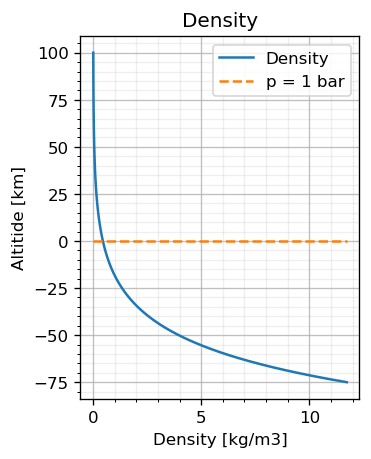

In [3]:
H_s = 23 # scale height [km]
rho_1 = 0.45 # density at 1 bar [kg/m3] 
R_nep = 24624 # radius of neptune at 1 bar [km]

def density(r):
    h = r-R_nep    
    rho = rho_1*np.exp(-h/H_s)
    return rho

# Plot
h_min = -75
h_max = 100
h_steps = 110
h_tab = np.linspace(h_min, h_max, h_steps)

r_tab = h_tab+R_nep

rho_tab = []

for r in r_tab:
    rho_tab.append(density(r))

plt.rcParams['figure.figsize'] = (3,4)    
plt.plot(rho_tab, h_tab, label='Density')
plt.plot([0,max(rho_tab)],[0, 0], '--', label='p = 1 bar')
plt.grid()
plt.legend()
plt.ylabel('Altitide [km]')
plt.xlabel('Density [kg/m3]')
plt.title('Density')

plt.minorticks_on()
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

### Pressure
returns results in bars <br>
galileo probe managed to go to 22.7 bars https://solarsystem.nasa.gov/missions/galileo-probe/in-depth/

26.072198765398173

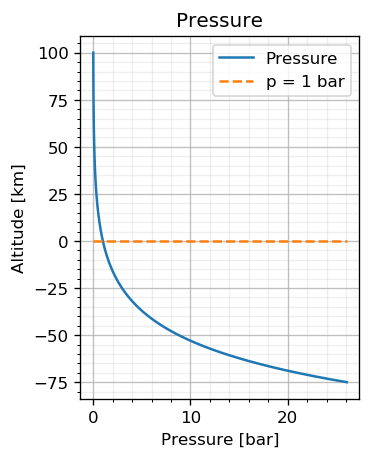

In [4]:
def pressure(r):
    h = r-R_nep
    p = np.exp(-h/H_s)
    return p

def altitude(p):
    h = H_s*np.log(1/p)
    return(h)

# Plot
h_min = -75
h_max = 100
h_steps = 110
h_tab = np.linspace(h_min, h_max, h_steps)

r_tab = h_tab+R_nep

p_tab = []

for r in r_tab:
    p_tab.append(pressure(r))

plt.rcParams['figure.figsize'] = (3,4)
plt.plot(p_tab, h_tab, label='Pressure')
plt.plot([0,max(p_tab)],[0, 0], '--', label='p = 1 bar')
plt.legend()
plt.ylabel('Altitude [km]')
plt.xlabel('Pressure [bar]')
plt.title('Pressure')

plt.minorticks_on()
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

pressure(-75+R_nep)

# Dynamics Simulation
all length units are in km <br>
outputs state in terms of km and s

### Functions
galileo aerodynamics: https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19960044628.pdf <br>
https://sjsu.edu/ae/docs/Neerja.Bangar.Sp18.pdf

In [5]:
Cd = 2.2 # taken from above links
mu = 6.8351e6 # taken from https://nssdc.gsfc.nasa.gov/planetary/factsheet/neptunefact.html

# instrument masses
m_tls = 8 
m_hasi = 6.3
m_h2o = 1
m_dop = 2
m_neph = 4.4
m_instr = m_tls+m_hasi+m_h2o+m_dop+m_neph
# other masses:
m_bat = 7.5 # from galileo
m_ant = 23.2 # from huygens
m_str = 30 # complete guess
m_other = m_bat+m_ant+m_str

#margins
m_mar = 0.5
hs_mar = 0.6 # heat shield mass is 60% times the rest (complete guess)

m = (1+hs_mar)*(1+m_mar)*(m_instr+m_other)

# spacecraft diamater:
d_sc = 0.75*1.4 # 75cm radius, 40% bigger for heat shield
A = np.pi*(d_sc/2)**2*1e-6 # space craft surface area [km2]
BC = m/(Cd*A) # Ballistic Coefficient [kg/km2]

def gravity(state,r): # acceleration, not force
    g = -mu/r**3*state[0:2]
    return(g)

print('total mass', m, '[kg]')
print('heat shield mass:', hs_mar/(1+hs_mar)*m, '[kg]')

total mass 197.76000000000005 [kg]
heat shield mass: 74.16000000000001 [kg]


In [15]:
def drag(state,r): # acceleration, not force
    rho = density(r) *1e9 # convert to kg/km3
    # WITH WIND:
    #theta_w = math.atan2(state[1],state[0]) + np.pi/2 # direction of wind
    #wind = 0.4*np.array([np.cos(theta_w),np.sin(theta_w)]) # change the constant for different wind conditions
    #v = np.linalg.norm(state[2:4]-wind)
    #d = -0.5*rho*v*(state[2:4]-wind)/BC
    # WITHOUT WIND:
    v = np.linalg.norm(state[2:4])
    d = -0.5*rho*v*state[2:4]/BC
    return(d)

def radius(state):
    r = np.linalg.norm(state[0:2])
    return(r)

r_min = R_nep - 75 # down to 100 bars

def orbit(state_0,dt,t_max):    
    state = state_0
    t = 0
    r = radius(state)
    state_tab = []
    while state[4] < t_max and r > r_min:
        r = radius(state)
        state[0:2] += dt*state[2:4] # propogate position with velocity
        if r < 25124: # h = 500 km, 325 -> rho = 3.3e-7, similiar to karman line
            dragstate = 0.1*np.array(state_tab[-4])+0.2*np.array(state_tab[-3])+0.3*np.array(state_tab[-2])+0.4*np.array(state_tab[-1])
            state[2:4] += dt*drag(dragstate,r) + dt*gravity(state,r)
        else:
            state[2:4] += dt*gravity(state,r)
        state[4] += dt
        state_tab.append(list(state))

    state_tab = np.array(state_tab)
    return(state_tab)

def time_state(state_tab,t): # takes in a tab of states and gives the one at a certain time
    for i in state_tab:
        if i[-1] >= t:
            state = np.array(i)
            break
    return(state)

def view_angle(state_relay,state_probe):
    state_rel = np.array(state_relay) - np.array(state_probe) # relative state
    theta_rel = math.degrees(math.atan2(state_rel[1],state_rel[0]))%360
    theta_probe = math.degrees(math.atan2(state_probe[1],state_probe[0]))%360

    view_angle = theta_rel - theta_probe
    if (view_angle>180):
        view_angle-=360

    return(view_angle)

### Initial Conditions

In [16]:
# TRIDENT
theta_triton = math.radians(22.5)  # guess from https://www.hou.usra.edu/meetings/lpsc2019/pdf/3200.pdf
a_triton = 354760 # [km] taken from p518 planetary sciences
x0 = 7e6
y0 = a_triton*np.sin(theta_triton)
v_tri = 20.8 # km/s, calculations on TI

state_0_tri = np.array([x0,y0,-v_tri,0,0])
t_max_tri = 50e4 # max time before sim stops
dt_tri = 5 # time step

state_tab_tri = orbit(state_0_tri,dt_tri,t_max_tri)

print('done (trident)')

# PROBE

delta_vx = 0.95 #change this to see what works
delta_vy = 0.3084474 # 0.3084474 is correct, use 0.32 for verification
dt = 1 # time step
t_max = 50e4 # max time before sim stops

vx = -v_tri - delta_vx
vy = - delta_vy

state_0 = np.array([x0,y0,vx,vy,0]) # initial state: x, y, xdot, ydot, t [km, s]
state_tab = orbit(state_0,dt,t_max)

print('done (probe)')

print('total delta v: ',math.sqrt(delta_vx**2+delta_vy**2))

done (trident)
done (probe)
total delta v:  0.9988192021415888


### Separate Data by Entrance
sutton graves constant from page 6 https://www.colorado.edu/event/ippw2018/sites/default/files/attached-files/aeroentrytech_13_dwyer_cianciolo_presid525_presslides_docid1111.pdf

sutton graves equations taken from page 17 https://tfaws.nasa.gov/TFAWS12/Proceedings/Aerothermodynamics%20Course.pdf


page 11 of https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20060020180.pdf: nose radius of apollo was 4.6939, diameter of body was 2x1.955 = 3.91, ratio of 1.2

In [17]:
h_cut_off = 500
entry_tab = []
R_nep = 24624 # radius of neptune at 1 bar [km]

for i in state_tab:
#    i = list(i)
    r = radius(i)
    if r < R_nep + h_cut_off:
        if len(entry_tab) == 0:
            entry_tab.append([i])
        elif i[4] - 2*dt > entry_tab[-1][-1][-1]:
            entry_tab.append([i])
        else:
            entry_tab[-1].append(i)

            
Rn = 1.2*d_sc # nose radius [m]
k = 0.6719e-4 # sutton graves constant, taken from colorado link
            
h_tab = []
a_tab = []
t_tab = []
t_real_tab = []
qc_tab = []

for i in entry_tab:
    h_tab.append([])
    a_tab.append([])
    t_tab.append([])
    qc_tab.append([])
    t_real_tab.append([])
    for j in i:
        
        r = radius(j)
        h_tab[-1].append(r-R_nep)

        a = np.linalg.norm(drag(j,r))*1000/9.81
        a_tab[-1].append(a)
        
        v = np.linalg.norm(j[2:4])*1e3
        qc = k*(density(r)/Rn)**0.5*v**3 # page 17 of nasa link
        
        qc_tab[-1].append(qc)
    
        t = j[4] - i[0][4]
        t_tab[-1].append(t)
        t_real_tab[-1].append(j[4])
print('done')

done


### View Angles

In [18]:
view_tab = []

for entry in range(len(entry_tab)):
    view_tab.append([])
    for pos in [0,-1]:
        t = entry_tab[entry][pos][-1]
        state_probe = time_state(state_tab, t)
        state_relay = time_state(state_tab_tri, t)
        
        view = view_angle(state_relay,state_probe)
        view_tab[-1].append(view)

print(view_tab)


t_start = entry_tab[-1][0][-1]
probe_start = time_state(state_tab,t_start)
relay_start = time_state(state_tab_tri,t_start)

t_fin = state_tab[-1][-1]
probe_fin = time_state(state_tab,t_fin)
relay_fin = time_state(state_tab_tri,t_fin)

link_start_x = np.array([probe_start[0],relay_start[0]])
link_start_y = np.array([probe_start[1],relay_start[1]])
link_fin_x = np.array([probe_fin[0],relay_fin[0]])
link_fin_y = np.array([probe_fin[1],relay_fin[1]])

[[-84.42233214332796, -111.10393640600354], [-22.83438601569474, -0.22086797364238464]]


### Figures


##### Orbit
haze and cloud altitude are taken from "Scientific rationale for Uranus and Neptunein situexplorations"

Text(288.7555029537041, 95.76077446583926, 'Triton (not\n to scale)')

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


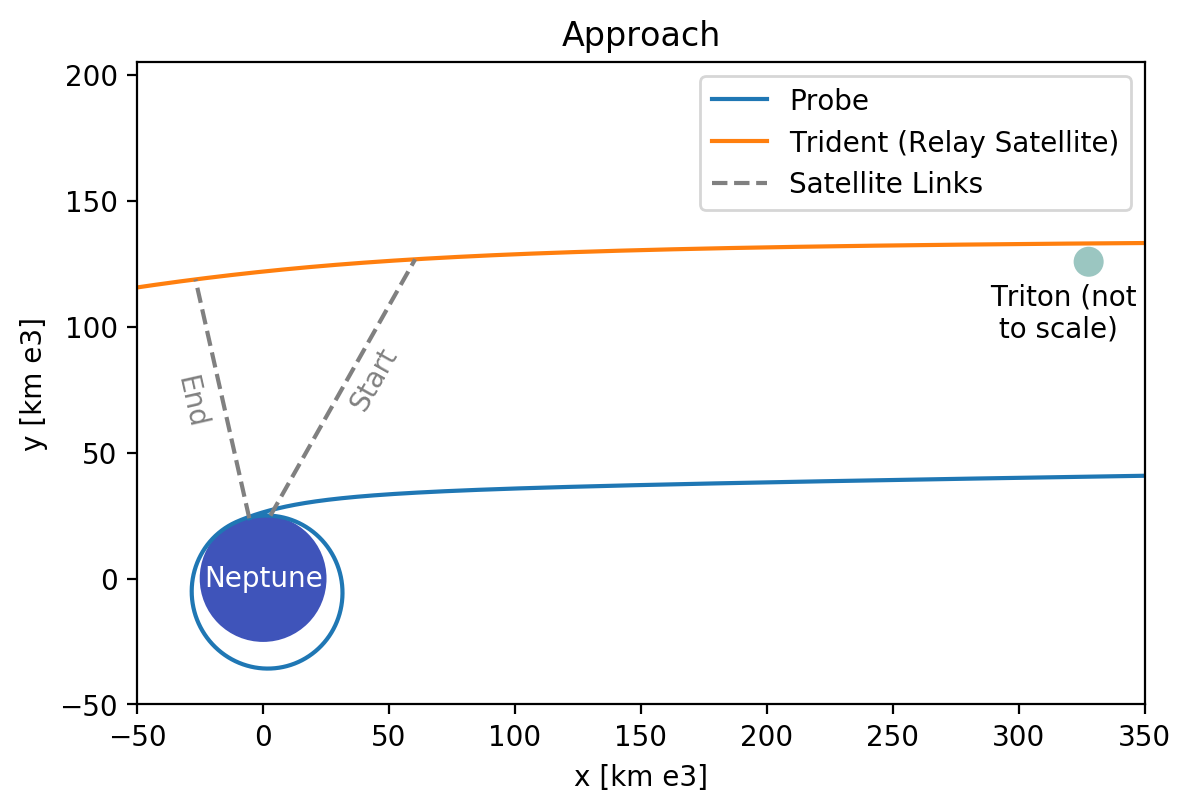

In [19]:
## from matplotlib import rc # tex package

plt.rcParams['figure.figsize'] = (6.5,6.5)
plt.rcParams['figure.dpi'] = 200 
plt.rcParams['figure.facecolor'] = 'white'

# Orbit
plt.figure()
plt.plot([x/1000 for x in state_tab[:,0]],[x/1000 for x in state_tab[:,1]],label = 'Probe')
plt.plot([x/1000 for x in state_tab_tri[:,0]],[x/1000 for x in state_tab_tri[:,1]],label='Trident (Relay Satellite)')
# satellite links
start_angle = math.atan2(link_start_y[1]-link_start_y[0],link_start_x[1]-link_start_x[0])
start_angle = math.degrees(start_angle)
end_angle = math.atan2(link_fin_y[1]-link_fin_y[0],link_fin_x[1]-link_fin_x[0])
end_angle = math.degrees(end_angle) - 180
plt.text(40,66,'Start', color='gray', rotation=start_angle, rotation_mode='anchor')
plt.text(-34,80,'End', color='gray', rotation=end_angle, rotation_mode='anchor')

plt.plot(link_start_x/1000,link_start_y/1000,'--',color='gray',label='Satellite Links')
plt.plot(link_fin_x/1000,link_fin_y/1000,'--',color='gray')

plt.title('Approach')
plt.xlabel('x [km e3]')
plt.ylabel('y [km e3]')
plt.legend()
plt.xlim([-50,350])
plt.ylim([-50,205])
plt.gca().set_aspect('equal', adjustable='box') # makes the axes be the same scale


# neptune and triton
R_nep = 24624
circle1=plt.Circle((0,0),R_nep/1000,color='#3f54ba')
plt.gcf().gca().add_artist(circle1)
plt.text(-23.5,-3,'Neptune',color='white')

R_triton = 1352*4 # [km] - 5x as big so its easier to see
theta_triton = 22.5*np.pi/180  # guess from https://www.hou.usra.edu/meetings/lpsc2019/pdf/3200.pdf
x_triton = a_triton*np.cos(theta_triton)*1e-3
y_triton = a_triton*np.sin(theta_triton)*1e-3 - 10
circle2=plt.Circle((x_triton,y_triton),R_triton/1000,color='#9BC6C1')
plt.gcf().gca().add_artist(circle2)
plt.text(x_triton-39, y_triton-30, 'Triton (not\n to scale)')

##### Altitude

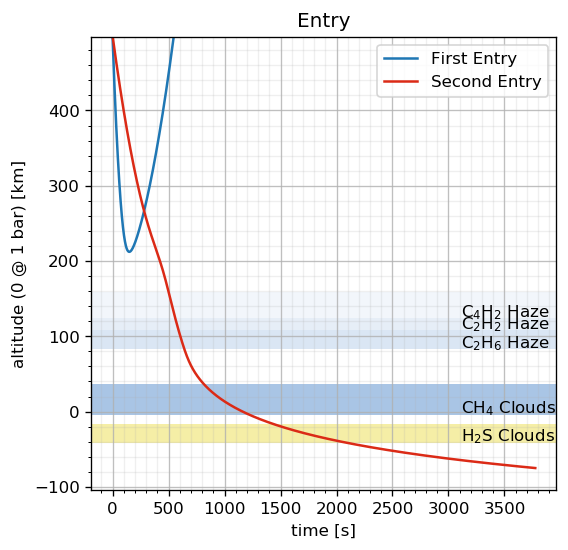

In [20]:
t_tabm = []
for i in t_tab:
    t_tabm.append([x/60 for x in i])


plt.rcParams['figure.dpi'] = 120 
plt.rcParams['figure.figsize'] = (5,5)
plt.gca().set_aspect('auto', adjustable='box') # makes the axes be the same scale

ordinal = ['First','Second','Third','Fourth','Fifth','Sixth','Seventh','Eighth','Ninth','Tenth']
plt.xlabel('time [s]')
plt.ylabel('altitude (0 @ 1 bar) [km]')
plt.title('Entry')
plt.xlim([-0.05*t_tab[-1][-1],1.05*t_tab[-1][-1]]) # so that margins dont respect clouds
# hazes and clouds
altitudes = [[4.5e-3,1e-3],[9e-3,4.5e-3],[27e-3,9e-3],[1200e-3,200e-3],[6,2]]
colors = ['#f2f6fb','#e6eef7','#dae6f4','#a9c5e5','#f5eea6']
names = ['C$_4$H$_2$ Haze','C$_2$H$_2$ Haze','C$_2$H$_6$ Haze','CH$_4$ Clouds','H$_2$S Clouds']

for i in range(len(altitudes)):
    y_bottom = altitude(altitudes[i][0])
    y_top = altitude(altitudes[i][1])
    height = y_top-y_bottom
    
    rectangle = plt.Rectangle((-1e3,y_bottom), 1e4, height, fc=colors[i])
    plt.gca().add_patch(rectangle)
    plt.text(t_tab[-1][-1]-660,y_bottom+2,names[i])

# entries
line_colors = ['#1f77b4','#db2a16']
for i in range(len(t_tab)):
    plt.plot(t_tab[i],h_tab[i],label = ordinal[i]+' Entry', color= line_colors[i])
        
plt.legend()
plt.ylim(ymax=h_tab[0][0])
#plt.xlim([0,4000])

plt.minorticks_on()
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

##### Acceleration

First Entry - max acceleration: 14.541966555598764 [g] at t = 134.0 [s]
Second Entry - max acceleration: 10.117142364408709 [g] at t = 488.0 [s]


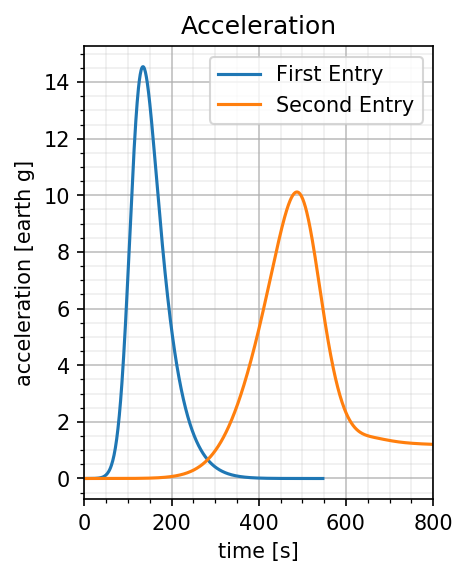

In [21]:
plt.rcParams['figure.dpi'] = 150 
plt.rcParams['figure.figsize'] = (3,4)
plt.figure()
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('acceleration [earth g]')
plt.title('Acceleration')


ordinal = ['First','Second','Third','Fourth','Fifth','Sixth','Seventh','Eighth','Ninth','Tenth']
for i in range(len(t_tab)):
    plt.plot(t_tab[i],a_tab[i],label = ordinal[i]+' Entry')

plt.minorticks_on()
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

plt.xlim([0,800])
#plt.ylim([0,16.5])

for i in range(len(t_tab)):
    for j in range(len(t_tab[i])):
        if a_tab[i][j] == max(a_tab[i]):
            a = a_tab[i][j]
            t = t_tab[i][j]
            print(ordinal[i],'Entry - max acceleration:',a, '[g] at t =', t, '[s]')
            break

#plt.legend(bbox_to_anchor=(0.32,0.68))
plt.legend()
#plt.text(205, 12.2, 'max$_1$ = 14.5') #, bbox=dict(facecolor='white', alpha=0.8, boxstyle = 'round'))
#plt.text(405, 10.5, 'max$_2$ = 10.1')

##### Heating

First Entry - max heating: 8.133822409851994 [MW/m2] at t = 119.0 [s]
First Entry - total heating: 929.3900881318285 [MJ/m2]
Second Entry - max heating: 1.3936128351447863 [MW/m2] at t = 395.0 [s]
Second Entry - total heating: 290.4269212382683 [MJ/m2]


Text(300, 1600, 'max$_2$ = 1390')

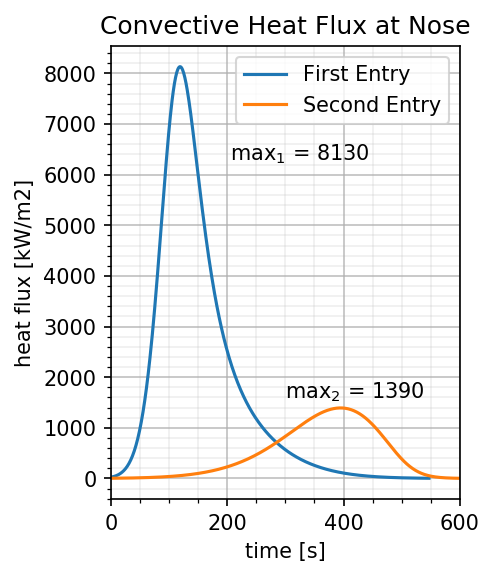

In [27]:
plt.rcParams['figure.figsize'] = (3,4)
plt.figure()
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('heat flux [kW/m2]')
plt.title('Convective Heat Flux at Nose')
for i in range(len(t_tab)):
    plt.plot(t_tab[i],[x/1000 for x in qc_tab[i]],label = ordinal[i]+' Entry')
plt.legend()
plt.minorticks_on()
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)
plt.xlim([0,600])


tot_heat = []
for i in qc_tab:
    tot_heat.append(dt*sum(i))

for i in range(len(t_tab)):
    for j in range(len(t_tab[i])):
        if qc_tab[i][j] == max(qc_tab[i]):
            qc = qc_tab[i][j]
            t = t_tab[i][j]
            print(ordinal[i],'Entry - max heating:',qc/1e6, '[MW/m2] at t =', t, '[s]')
            break
    print(ordinal[i],'Entry - total heating:',tot_heat[i]/1e6, '[MJ/m2]')
            
plt.text(205, 6300, 'max$_1$ = 8130') #, bbox=dict(facecolor='white', alpha=0.8, boxstyle = 'round'))
plt.text(300, 1600, 'max$_2$ = 1390')

In [33]:
# this is for verification of the heat heat shield:
for i in qc_tab:
    idx = i.index(max(i));
    print(ordinal[qc_tab.index(i)],'Entry velocity at maximum heat flux: ', \
          np.linalg.norm(entry_tab[0][idx][2:4]), '[km/s]')

First Entry velocity at maximum heat flux:  28.972769374917533 [km/s]
Second Entry velocity at maximum heat flux:  17.968697634156847 [km/s]


### Entry Velocities

In [23]:
entry_v_1 = np.linalg.norm(entry_tab[0][0][2:4])
exit_v_1 = np.linalg.norm(entry_tab[0][-1][2:4])
#entry_v_2 = np.linalg.norm(entry_tab[1][0][2:4])

gamma_1 = abs(math.atan2(entry_tab[0][0][1],entry_tab[0][0][0])%(2*np.pi) \
    - math.atan2(entry_tab[0][0][3],entry_tab[0][0][2])%(2*np.pi)) - np.pi/2
#gamma_2 = abs(math.atan2(entry_tab[0][1][1],entry_tab[0][1][0])%(2*np.pi) \
#    - math.atan2(entry_tab[0][1][3],entry_tab[0][1][2])%(2*np.pi)) - np.pi/2

print('Entry Velocity (First Entry):',entry_v_1,'km/s')
print('Entry Angle (First Entry):', np.degrees(gamma_1), 'degrees')
print('Exit Velocity (First Entry):',exit_v_1,'km/s')

#print('')
#print('Entry Velocity (Second Entry):',entry_v_2,'km/s')
#print('Entry Angle (Second Entry):', np.degrees(gamma_2), 'degrees')

# time for trident to fly through tritons orbit to verify from nasa doc (should be 8.2 hrs or so)
for state in state_tab_tri:
    if radius(state[0:2]) <= a_triton:
        t_orbit_start = state[-1]
        break

for state in state_tab_tri:
    t = state[-1]
    if t > t_orbit_start and radius(state[0:2]) >= a_triton:
        t_orbit_end = t
        break
        
t_orbit_total = t_orbit_end-t_orbit_start

print('')
print('Time for Trident to Pass through Triton\'s Orbit:',t_orbit_total/60**2, 'hrs')
print('Time Trident First Comes Through Orbit:', t_orbit_start/60**2, 'hrs')

Entry Velocity (First Entry): 31.856416277207654 km/s
Entry Angle (First Entry): 7.382213119478983 degrees
Exit Velocity (First Entry): 17.872863686053623 km/s

Time for Trident to Pass through Triton's Orbit: 8.518055555555556 hrs
Time Trident First Comes Through Orbit: 88.66527777777777 hrs
